# Détectez les Bad Buzz grâce au Deep Learning




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

In [2]:
dir_data = "./data/"

In [3]:
df_nlp = pd.read_csv(dir_data + "training.1600000.processed.noemoticon.csv",
                     encoding="ISO-8859-1",
                     header=None,
                     names=["target","id","date","flag","user","text"])

In [4]:
df_nlp.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
%%time
df_nlp["date"] = pd.to_datetime(df_nlp["date"].apply(lambda x : x.replace("PDT ", "")).values,errors="ignore")

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 2min 41s


In [7]:
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   id      1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   flag    1600000 non-null  object        
 4   user    1600000 non-null  object        
 5   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 73.2+ MB


In [8]:
df_nlp["target"].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [9]:
df_nlp["flag"].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

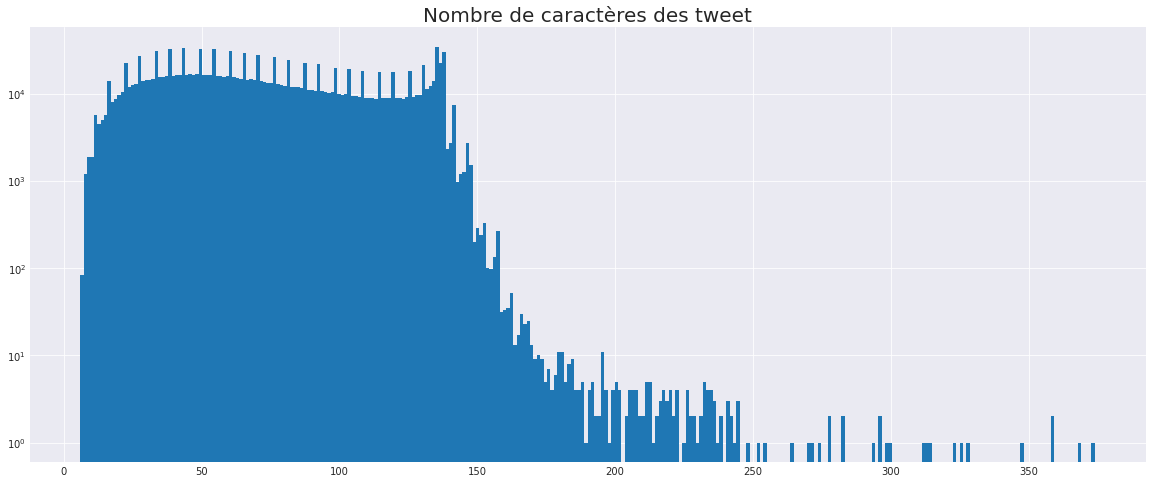

In [10]:
plt.figure(figsize=(20,8))
plt.hist(df_nlp["text"].apply(lambda x: len(x)).values,bins=300)
plt.yscale("log")
plt.title("Nombre de caractères des tweet",fontsize=20)
plt.show()

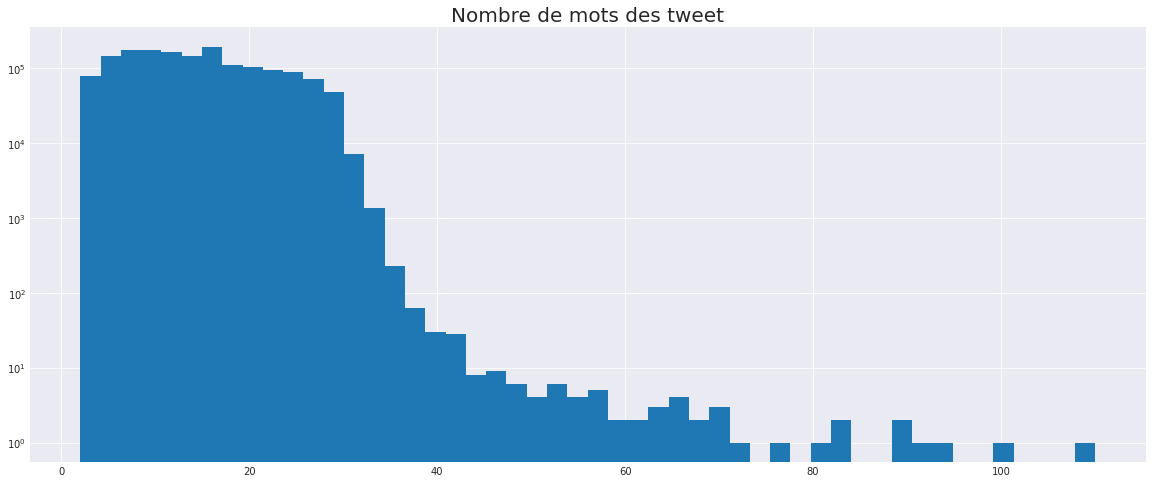

In [11]:
plt.figure(figsize=(20,8))
plt.hist(df_nlp["text"].apply(lambda x: len(x.split(" "))).values,bins=50)
plt.yscale("log")
plt.title("Nombre de mots des tweet",fontsize=20)
plt.show()

In [12]:
df_nlp.index = df_nlp["date"]

date
2009-04-30    100025
2009-05-31    576367
2009-06-30    923608
Freq: M, Name: id, dtype: int64


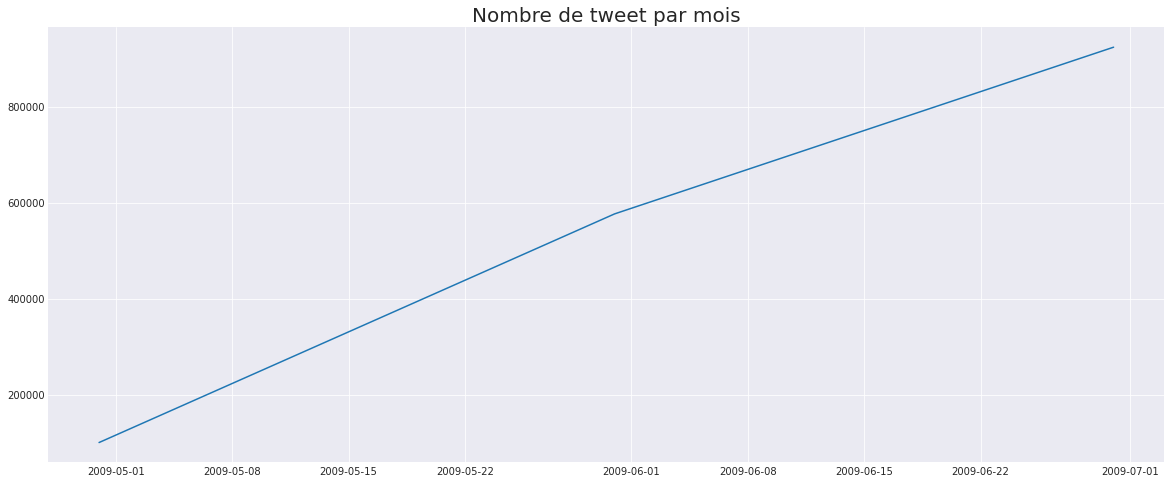

In [13]:
plt.figure(figsize=(20,8))
sample_month = df_nlp["id"].resample("M").count()
print(sample_month)
plt.plot(sample_month)
plt.title("Nombre de tweet par mois",fontsize=20)
plt.show()

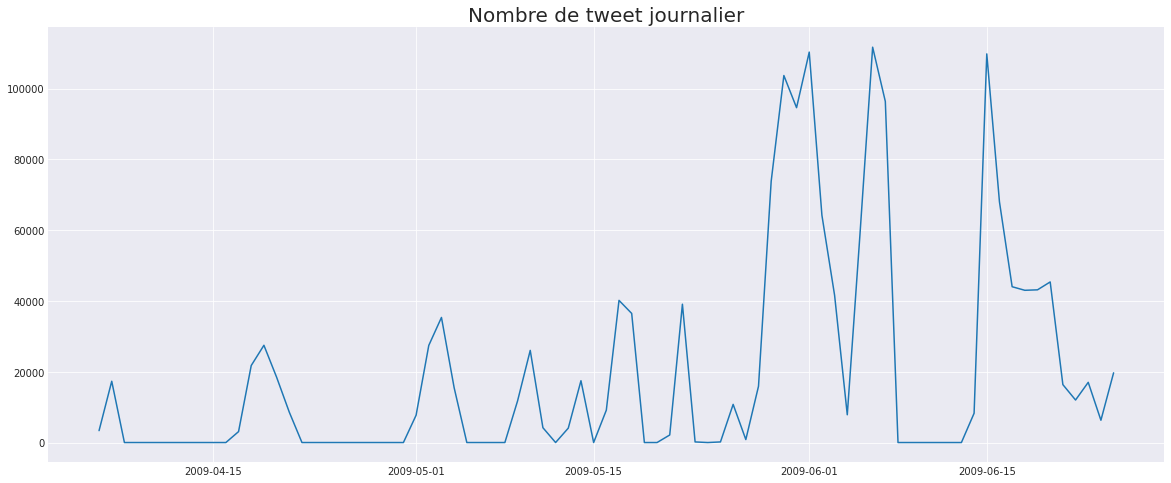

In [14]:
plt.figure(figsize=(20,8))
sample_month = df_nlp["id"].resample("D").count()
plt.plot(sample_month)
plt.title("Nombre de tweet journalier",fontsize=20)
plt.show()

In [15]:
best_10_tweet_user = df_nlp.groupby("user")["id"].count().sort_values(ascending=False).iloc[:10]

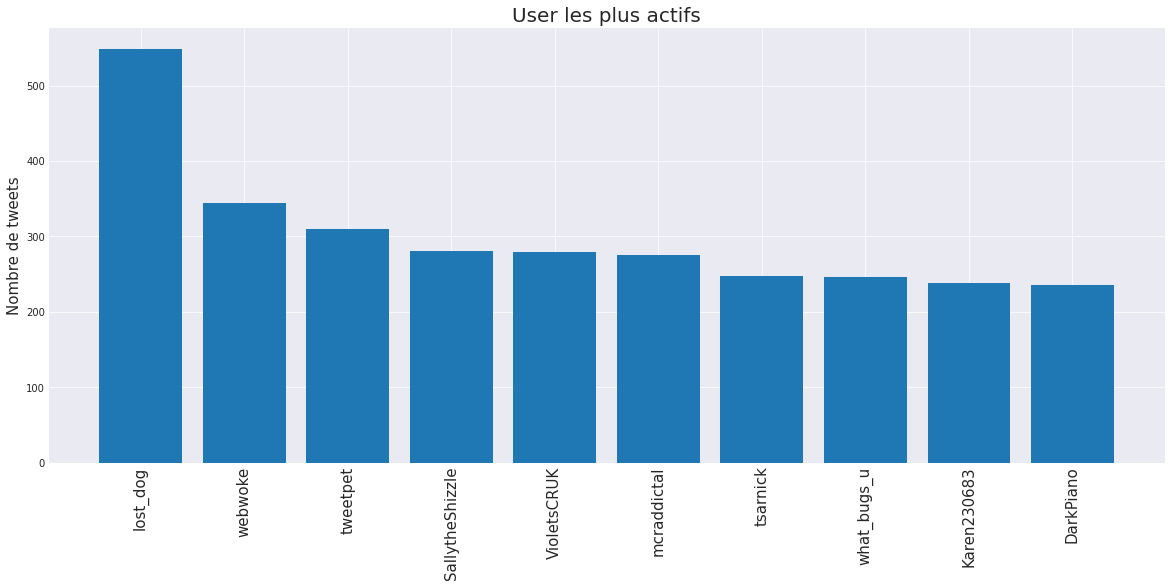

In [16]:
plt.figure(figsize=(20,8))
plt.bar(best_10_tweet_user.index,best_10_tweet_user.values)
plt.title("User les plus actifs",fontsize=20)
plt.ylabel("Nombre de tweets",fontsize=15)
plt.xticks(rotation=90,fontsize=15)
plt.show()

In [17]:
all_word = {}
def add_text(text):
    words = text.split(" ")
    for w in words:
        if w in all_word.keys():
            all_word[w] +=1
        else:
            all_word[w] = 1
_ = df_nlp["text"].apply(lambda x : add_text(x))

In [18]:
sort_count_word = dict(sorted(all_word.items(), key=lambda item: item[-1], reverse=True))

In [19]:
top_10_word_used  = {}
for _,k in zip(range(10),sort_count_word.items()):
    top_10_word_used[k[0]]= k[1]

{'': 1930617, 'to': 552962, 'I': 496608, 'the': 487500, 'a': 366212, 'my': 280025, 'and': 275263, 'i': 249975, 'is': 217692, 'you': 213871}


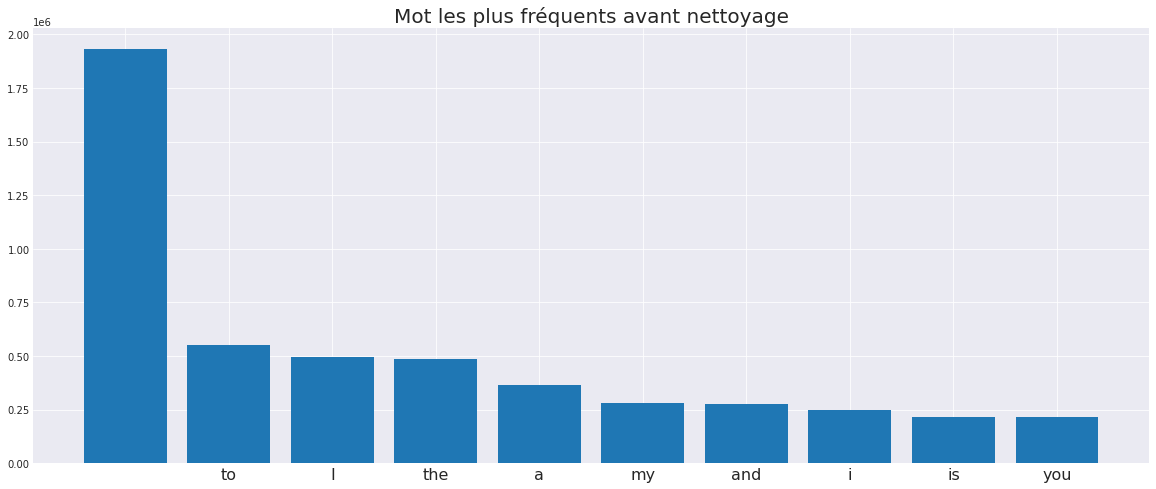

In [20]:
plt.figure(figsize=(20,8))
print(top_10_word_used)
plt.bar(top_10_word_used.keys(),top_10_word_used.values())
plt.title("Mot les plus fréquents avant nettoyage",fontsize=20)
plt.xticks(fontsize=16)
plt.show()

In [21]:
import spacy
from wordcloud import WordCloud

In [22]:
df_nlp["sentiment"] = df_nlp["target"].apply(lambda x : "good" if x==4 else "bad").values

nlp_for_exclude_sw = spacy.load("en_core_web_sm")
sw = nlp_for_exclude_sw.Defaults.stop_words

In [33]:
sw.update(["lol","haha","oh","ah","ok","yay","ye"])

In [34]:
def clean_sw(data):
    extract = " ".join([tweet for tweet in data])
    return " ".join([w for w in extract.lower().split(" ") if not w in sw])
def plot_wordcloud(txt, max_words=50,background_color="white",figsize=(12,10)):
    wordcloud = WordCloud(background_color = background_color, max_words = max_words).generate(txt)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

In [35]:
clean_extract = clean_sw(df_nlp["text"].values)

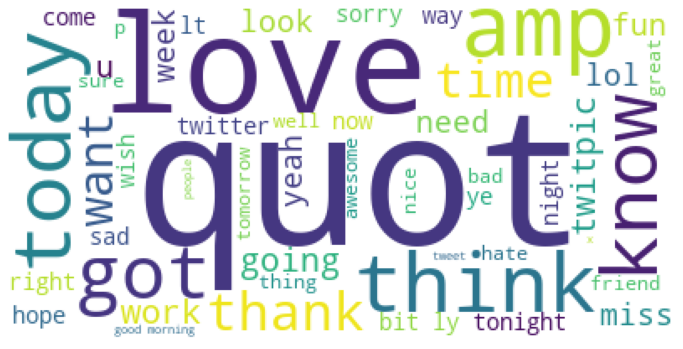

In [36]:
plot_wordcloud(clean_extract)

In [37]:
import utility_method as utility
clean_extract = utility.cleanning_data(clean_extract)

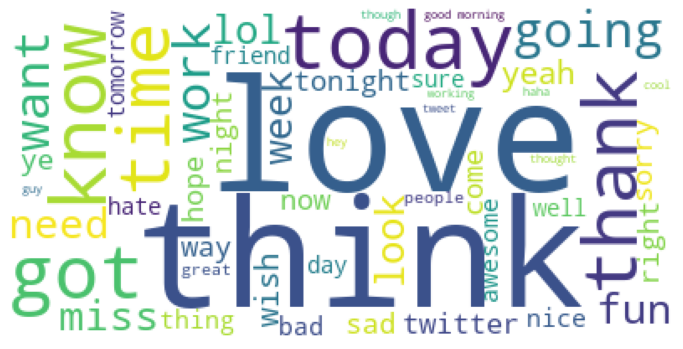

In [38]:
plot_wordcloud(clean_extract)

In [39]:
bad_tweet = df_nlp[df_nlp["sentiment"] == "bad"]["text"].values
good_tweet = df_nlp[df_nlp["sentiment"] == "good"]["text"].values

In [40]:
bad_clean = utility.cleanning_data(clean_sw(bad_tweet))
good_clean = utility.cleanning_data(clean_sw(good_tweet))

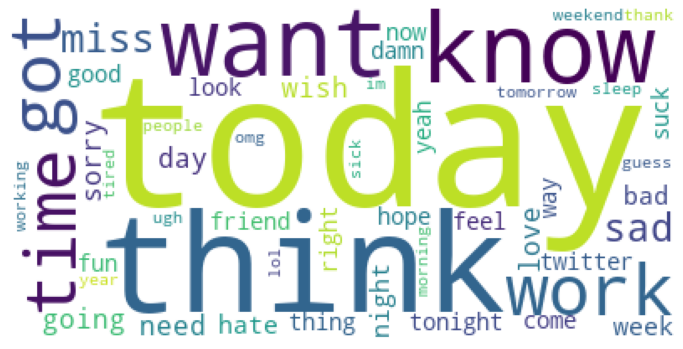

In [41]:
plot_wordcloud(bad_clean)

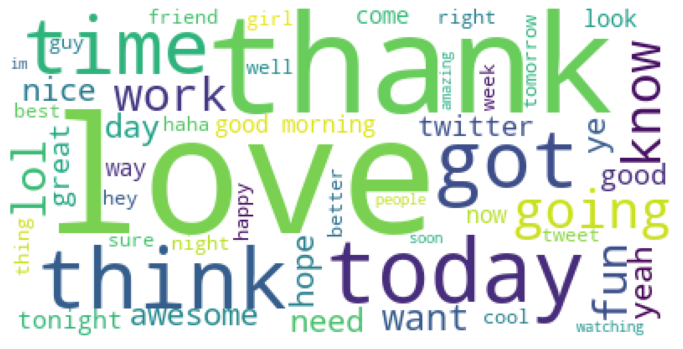

In [42]:
plot_wordcloud(good_clean)

# Creation d'un petit dataset (ML_STUDIO & cognitive_service)

### Global dataset
Permet d'avoir le jeu de données avec uniquement les informations importantes

In [24]:
df_nlp["sentiment"] = df_nlp["target"].apply(lambda x : "good" if x==4 else "bad").values

In [25]:
final_df = df_nlp.drop(["id","flag","user","date","target"],axis=1).copy()

In [26]:
final_df.to_csv(dir_data + "final_dataset.csv")

## Echantillion 10.000 données stratifiées

In [27]:
X_train = final_df["text"].values
y_train = final_df["sentiment"].values

In [28]:
y_train[0]

'bad'

In [29]:
new_size=10000
size=new_size//2

pos_X = []
i = 0
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(X_train[i])
    i+=1

i=0
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(X_train[i])
    i+=1
reduce_X = pos_X

reduce_X.extend(neg_X)
reduce_Y = ["good" for i in range(size)]
reduce_Y.extend(["bad" for i in range(size)])

In [30]:
sample_df = pd.DataFrame(reduce_X,columns=["text"])

In [31]:
sample_df["sentiment"] = reduce_Y

In [32]:
sample_df.to_csv(dir_data + "sample_final_dataset.csv")

In [33]:
pd.read_csv(dir_data + "sample_final_dataset.csv",index_col=0).head()

,text,sentiment
0,I LOVE @Health4UandPets u guys r the best!!,good
1,im meeting up with one of my besties tonight! ...,good
2,"@DaRealSunisaKim Thanks for the Twitter add, S...",good
3,Being sick can be really cheap when it hurts t...,good
4,@LovesBrooklyn2 he has that effect on everyone,good


In [34]:
index = 14758
print(final_df["text"].iloc[index],"\nsentiment :",final_df["sentiment"].iloc[index])

i lose followers all the time.  haha 
sentiment : bad


In [35]:
index = 25894
print(final_df["text"].iloc[index],"\nsentiment :",final_df["sentiment"].iloc[index])

I feel like i have a hangover... But i didn't really drink alot last night.  
sentiment : bad


## Echantillion 4.000 données stratifiées

In [42]:
new_size=4000
size=new_size//2

pos_X = []
i = 1500000
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(X_train[i])
    i+=1

i=700000
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(X_train[i])
    i+=1
reduce_X = pos_X

reduce_X.extend(neg_X)
reduce_Y = ["good" for i in range(size)]
reduce_Y.extend(["bad" for i in range(size)])

In [45]:
sample_df_test = pd.DataFrame(reduce_X,columns=["text"])
sample_df_test["sentiment"] = reduce_Y

In [47]:
sample_df_test.to_csv(dir_data + "sample_test_dataset.csv")

In [48]:
sample_df_test

,text,sentiment
0,Chillin @ the beach with my girl brit-brit wat...,good
1,@indraherlambang really wanna say that ure lik...,good
2,"@ambermac Gotta love Brad Pitt's performance, ...",good
3,Just realized that Matthew Sweet &amp; Susanna...,good
4,"@marksphone sorry, meant that to come from my ...",good
...,...,...
3995,Got an iPod touch from joeyy but only to borrow,bad
3996,@figmdn I am lost. Please help me find a good ...,bad
3997,had an eventful time but now feels sad maybe ...,bad
3998,@DonnieWahlberg I need a twug. I just got pick...,bad
